# Import

In [1]:
import mediapipe as mp

# Onna her bør allerede vera i main notebook
import os
import cv2
import codecs
import json
import matplotlib.pyplot as plt

In [2]:
# Defs og ting som allerede e i main booken, trenge ikkje ta me denne cellen
class_names = [d for d in os.listdir('images/train_original')]
img_height = 300
img_width = 300
batch_size = 32

# Adds filenames with a specific file extension in a directory to a list
def files_to_list(directory_path, file_extension):
    files = []
    for file in os.listdir(directory_path):
        if file.endswith(file_extension):
            files.append(os.path.join(directory_path, file))
    return files

# Adds files image filenames in directory to dictionary
def img_to_dict(directory_path):
    img_dict = {}
    for c in class_names:
        img_dict[c] = []
        for img_file in os.listdir(directory_path + c):
            img_dict[c].append(img_file.replace('.jpg', ''))
    return img_dict

# Adds data from a list of json filepaths to dictionary
def json_to_dict(files, img_dict):
    return_dict = {}
    classindex = 0
    for file in files:
        current_class = class_names[classindex]
        class_annotations = {}
        with codecs.open(file,'r','utf-8') as f: 
            annotations = json.load(f)
            for annotation in annotations:
                if annotation in img_dict[current_class]:
                    class_annotations[annotation] = annotations[annotation]
        classindex += 1
        return_dict[current_class] = class_annotations
    return return_dict


# Adding all annotation files to a list
files = files_to_list('data/train', '.json')

# Adding train images to dictionary
train_img_dict = img_to_dict('images/train_original/')

# Exporting training json data from file to dictionary
data = json_to_dict(files, train_img_dict)

# Detecting and extracing hand(s) from images
A function that uses the library mediapipe to find hands and hand landmarks.
It finds and crops out the hand.
Then stores this in a "hand" class that contains the list of landmarks, and the cropped image.

In [3]:
class humanHand:
    def __init__(self, landmarks, croppedimage, resized) -> None:
        self.landmarks: list = landmarks
        self.cimg = croppedimage
        self.resized = resized
    

def detectHand(im, maxHands=2, conf=0.7, borderMargin=50) -> list[humanHand]:
    #Using mediapipe to recoqnize hands
    handAlgo = mp.solutions.hands
    hands = handAlgo.Hands(max_num_hands=maxHands, min_detection_confidence=conf)
    imy , imx, c = im.shape
    h = hands.process(im)

    if not h.multi_hand_landmarks:
        return None
        
    handList: list[humanHand] = []
    for hl in h.multi_hand_landmarks:
        xma, yma = 0, 0
        xmi, ymi = imx, imy
        landmarks = []
        for lm in hl.landmark:
            x = int(lm.x * imx)
            y = int(lm.y * imy)
            landmarks.append([x,y])
            xma = x if x > xma else xma
            yma = y if y > yma else yma
            xmi = x if x < xmi else xmi
            ymi = y if y < ymi else ymi
    
        if xma+borderMargin < imx and yma+borderMargin < imy: # Add a bit of margin around hand if possible
            xma += borderMargin
            yma += borderMargin
        if xmi-borderMargin >= 0 and ymi-borderMargin >= 0:
            xmi -= borderMargin
            ymi -= borderMargin
        cropped_image = im[ymi:yma, xmi:xma]
        resized_image = cv2.resize(cropped_image, (img_height, img_width), interpolation= cv2.INTER_LINEAR)
        h = humanHand(landmarks=landmarks, croppedimage=cropped_image, resized=resized_image)
        handList.append(h)
    return handList

# Testing the function


Detected hands: 1


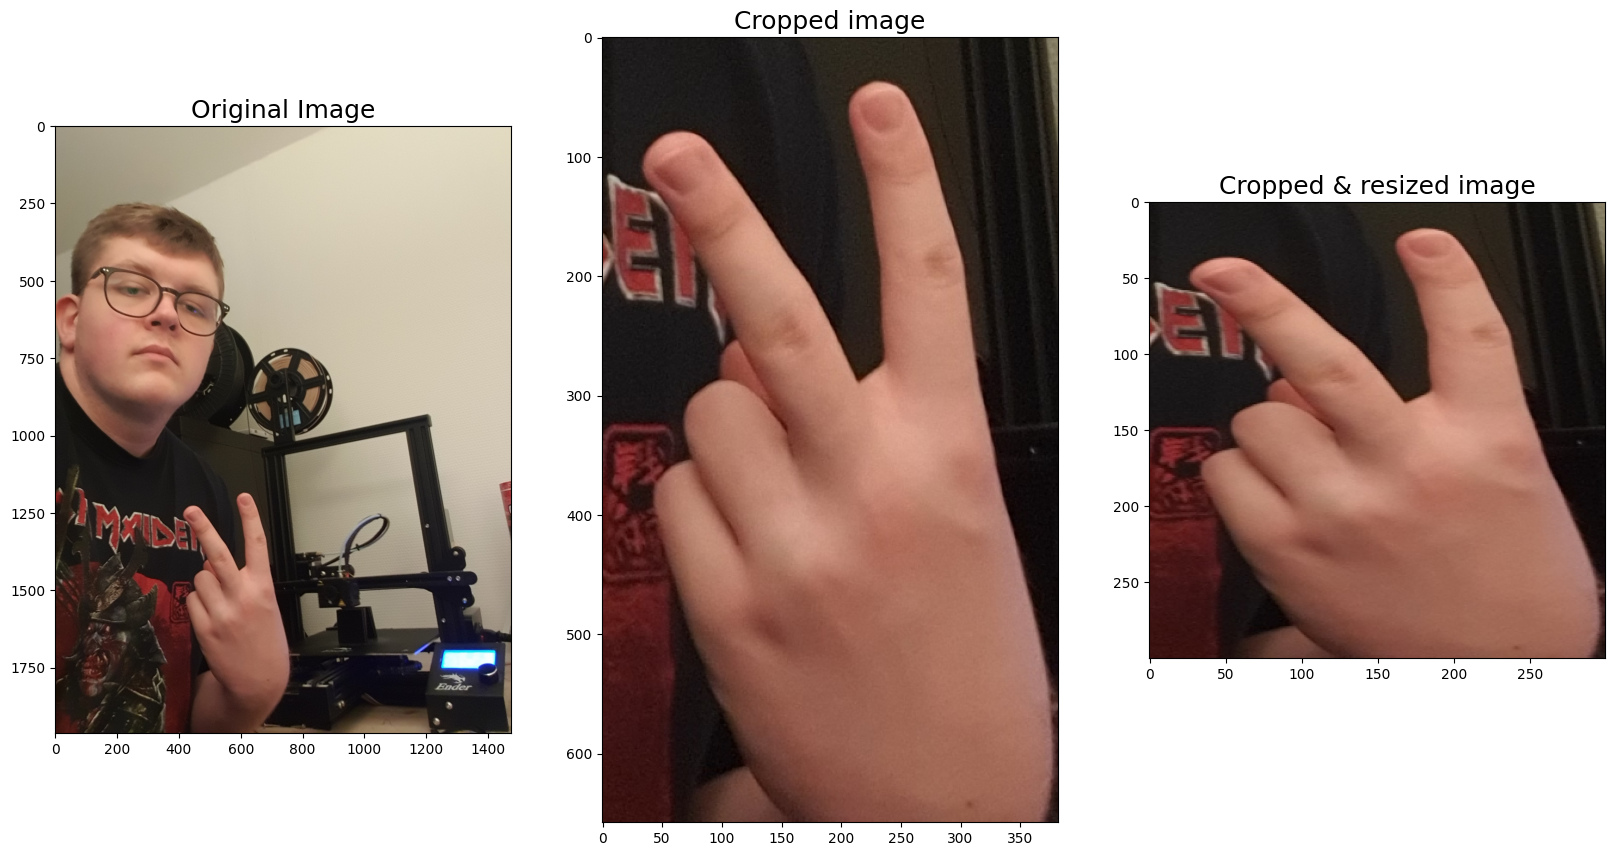

In [4]:
im = cv2.imread('images\\testCropFunc.jpg')[...,::-1]

hand = detectHand(im, 2, borderMargin=60)
print(f"Detected hands: {len(hand)}")

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.title('Original Image', fontsize=18)
plt.imshow(im)
plt.subplot(132)
plt.title('Cropped image', fontsize=18)
plt.imshow(hand[0].cimg)
plt.subplot(133)
plt.title('Cropped & resized image', fontsize=18)
plt.imshow(hand[0].resized)
plt.show()

Detected hands: 2


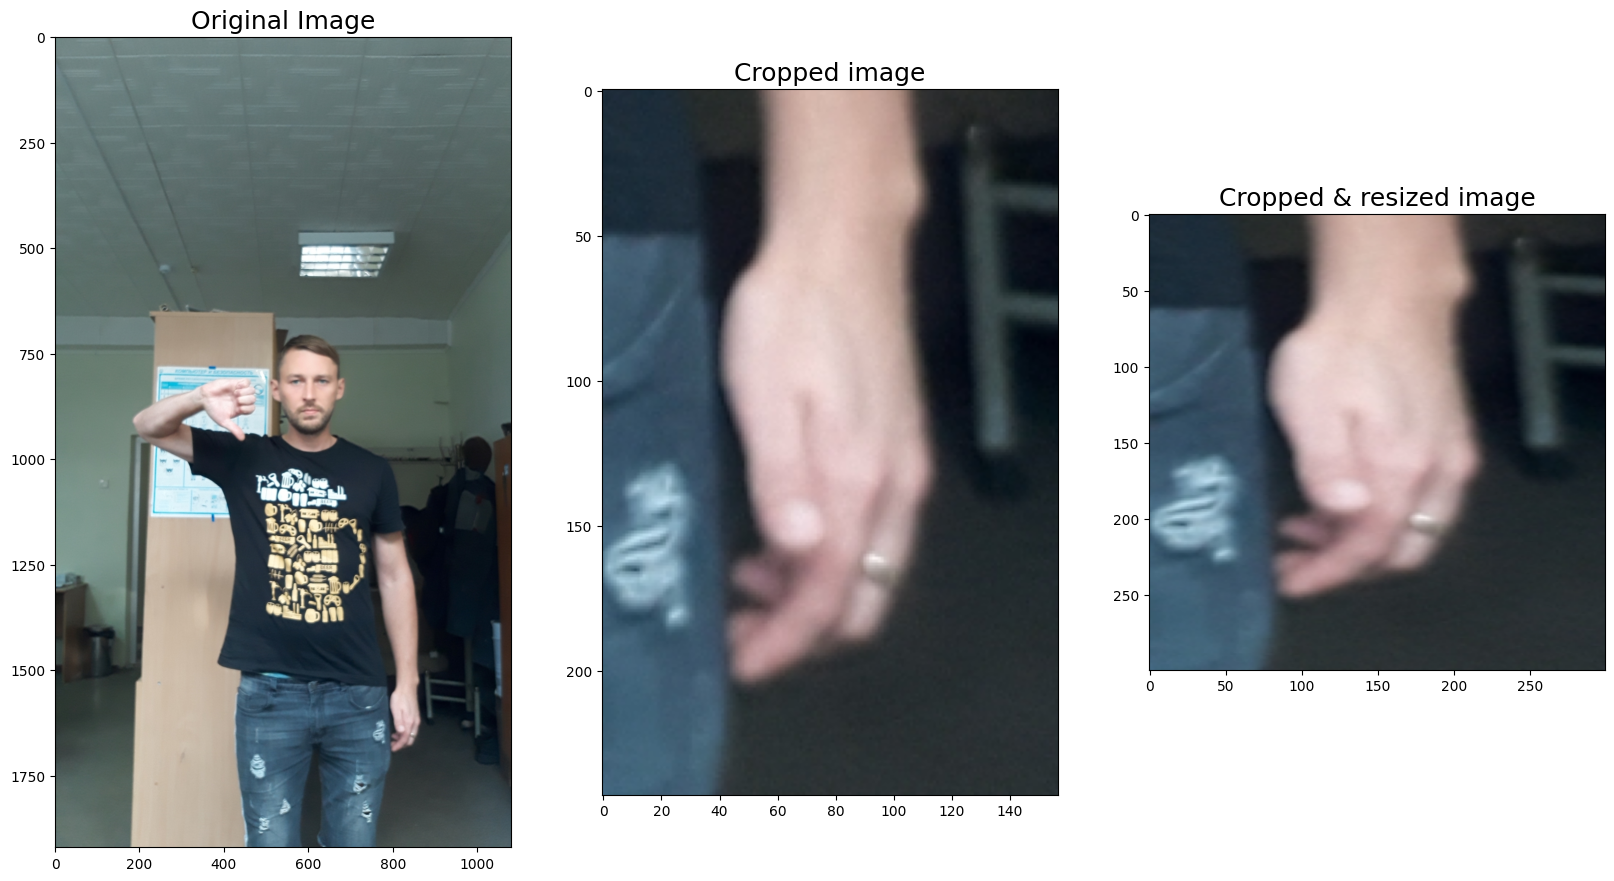

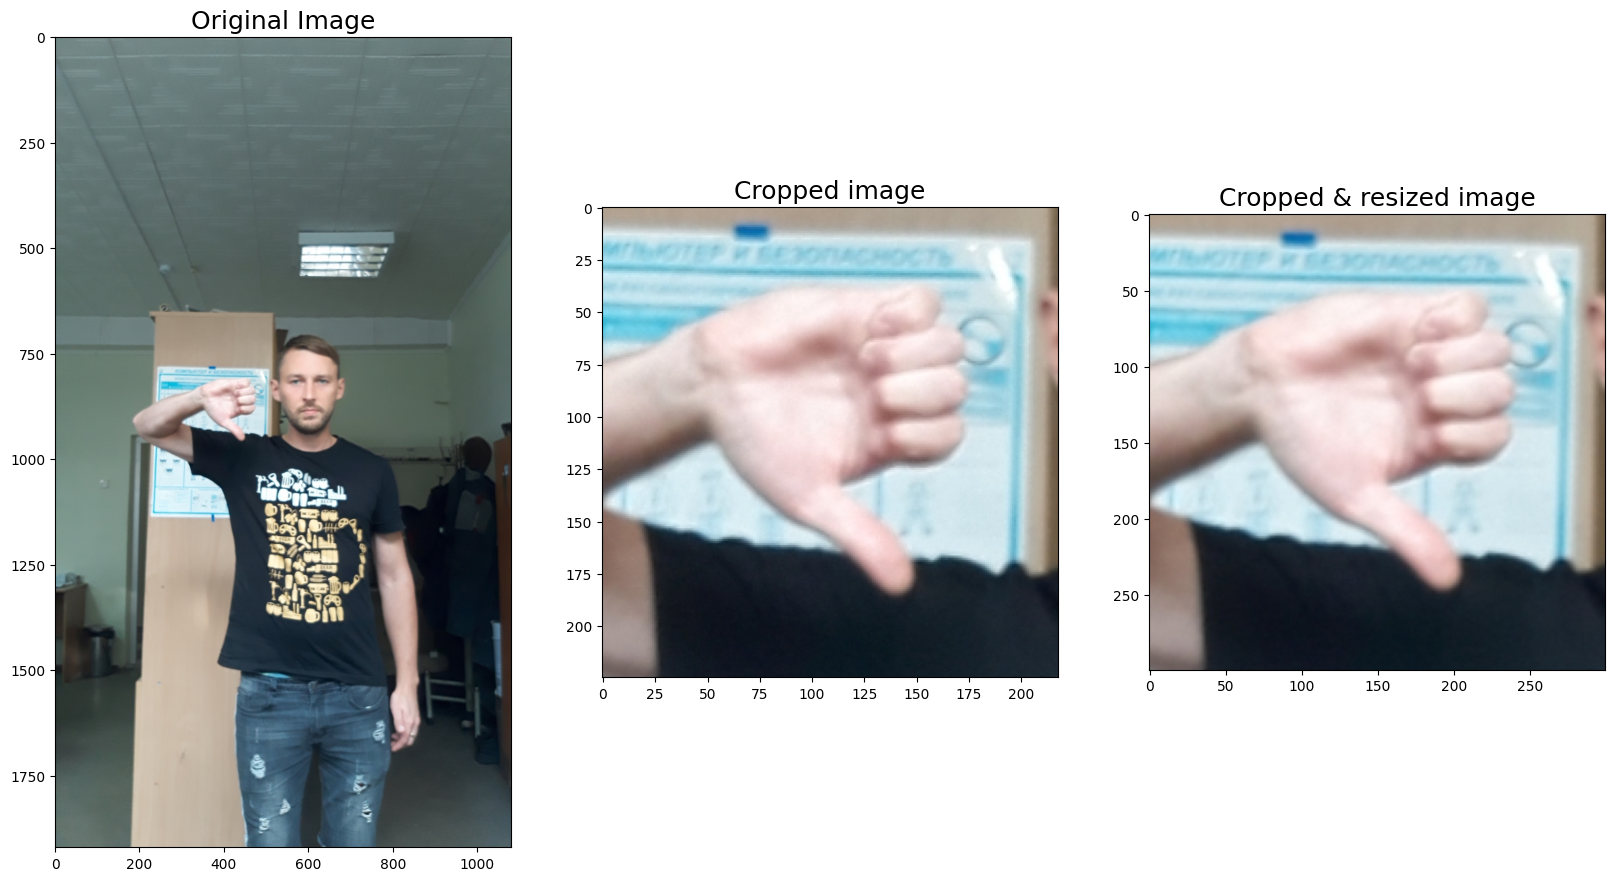

In [5]:
im = cv2.imread('images\\train_original\\dislike\\00a5bf41-da88-49cd-88b5-b7d0a4e6158f.jpg')[...,::-1]

hand = detectHand(im, 2, 0.9)

print(f"Detected hands: {len(hand)}")


plt.figure(figsize=(20,20))
plt.subplot(131)
plt.title('Original Image', fontsize=18)
plt.imshow(im)
plt.subplot(132)
plt.title('Cropped image', fontsize=18)
plt.imshow(hand[0].cimg)
plt.subplot(133)
plt.title('Cropped & resized image', fontsize=18)
plt.imshow(hand[0].resized)
plt.show()

# Can detect both hands
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.title('Original Image', fontsize=18)
plt.imshow(im)
plt.subplot(132)
plt.title('Cropped image', fontsize=18)
plt.imshow(hand[1].cimg)
plt.subplot(133)
plt.title('Cropped & resized image', fontsize=18)
plt.imshow(hand[1].resized)
plt.show()